Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import neurokit2 as nk
from collections import Counter
from scipy import signal
from scipy.fft import fft, fftfreq
import wfdb
import warnings

warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


Load ECG Dataset

In [8]:
def load_ecg_data(record_id='04015'):
    """
    Load ECG data dari MIT-BIH AF database
    """
    try:
        record = wfdb.rdrecord(record_id, pn_dir='afdb')
        ecg_signal = record.p_signal[:, 0]  # Lead 1 only
        fs = record.fs
        
        print(f"✓ Record {record_id} loaded successfully")
        print(f"  Signal length: {len(ecg_signal):,} samples")
        print(f"  Duration: {len(ecg_signal)/fs/60:.1f} minutes")
        print(f"  Sampling frequency: {fs} Hz")
        
        return ecg_signal, fs, record_id
        
    except Exception as e:
        print(f"❌ Error loading record {record_id}: {e}")
        return None, None, None

# Load data
record_id = '04015'  # Define record ID
ecg_signal, fs, record_id = load_ecg_data(record_id)

if ecg_signal is not None:
    processed_ecg = ecg_signal.copy()
    processed_fs = fs
    print(f"\n✅ Data loaded and ready for processing")
else:
    print("❌ Failed to load data")

✓ Record 04015 loaded successfully
  Signal length: 9,205,760 samples
  Duration: 613.7 minutes
  Sampling frequency: 250 Hz

✅ Data loaded and ready for processing


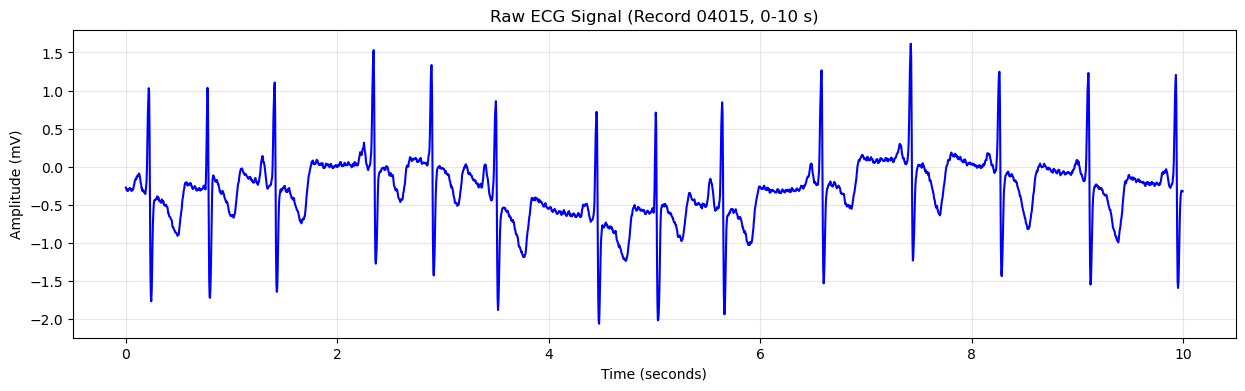

In [9]:
if ecg_signal is not None:

    # Tentukan segment waktu untuk plot (misal 0-10 detik)
    start_time = 0    # detik
    end_time   = 10   # detik
    start_sample = int(start_time * fs)
    end_sample   = int(end_time * fs)

    ecg_segment = ecg_signal[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    plt.figure(figsize=(15, 4))
    plt.plot(time_axis, ecg_segment, color='b')
    plt.title(f"Raw ECG Signal (Record {record_id}, {start_time}-{end_time} s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.show()


Apply Filtering

In [10]:
def apply_comprehensive_filtering(ecg_signal, fs):
    """
    Apply comprehensive filtering: DC removal + Bandpass + Notch
    """
    print("=== Applying Comprehensive Filtering ===")
    
    # Step 1: DC removal
    ecg_dc_removed = ecg_signal - np.mean(ecg_signal)
    print(f"✓ DC offset removed (mean was: {np.mean(ecg_signal):.4f})")
    
    # Step 2: Bandpass filter (0.5-40 Hz)
    nyquist = fs / 2
    low_cutoff = 0.5 / nyquist
    high_cutoff = 40.0 / nyquist
    
    bp_b, bp_a = signal.butter(4, [low_cutoff, high_cutoff], btype='band')
    ecg_bandpass = signal.filtfilt(bp_b, bp_a, ecg_dc_removed)
    print("✓ Bandpass filter applied (0.5-40 Hz)")
    
    # Step 3: Notch filter (50 Hz)
    notch_freq = 50.0 / nyquist
    notch_b, notch_a = signal.iirnotch(notch_freq, Q=25)
    ecg_filtered = signal.filtfilt(notch_b, notch_a, ecg_bandpass)
    print("✓ Notch filter applied (50 Hz)")
    
    # Quality check
    print(f"\nFiltering Results:")
    print(f"  Original - Mean: {np.mean(ecg_signal):.4f}, Std: {np.std(ecg_signal):.4f}")
    print(f"  Filtered - Mean: {np.mean(ecg_filtered):.4f}, Std: {np.std(ecg_filtered):.4f}")
    
    return ecg_filtered

# Apply filtering
if ecg_signal is not None:
    filtered_ecg = apply_comprehensive_filtering(processed_ecg, processed_fs)
    print("\n✅ Filtering completed successfully")

=== Applying Comprehensive Filtering ===
✓ DC offset removed (mean was: -0.2725)
✓ Bandpass filter applied (0.5-40 Hz)
✓ Notch filter applied (50 Hz)

Filtering Results:
  Original - Mean: -0.2725, Std: 0.7442
  Filtered - Mean: -0.0000, Std: 0.4313

✅ Filtering completed successfully


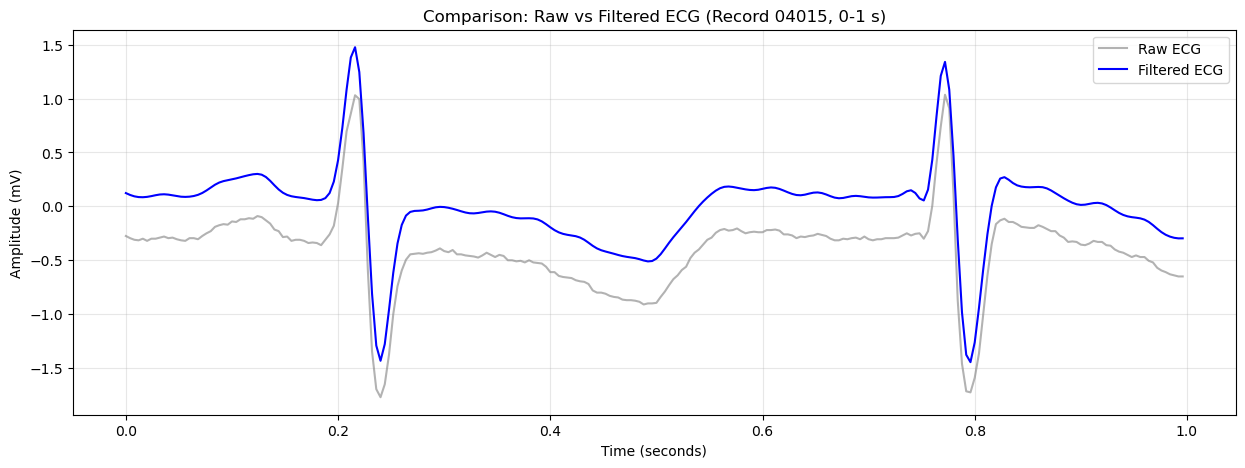

In [49]:
if ecg_signal is not None and filtered_ecg is not None:

    # Tentukan segment waktu untuk plot (misal 0-10 detik)
    start_time = 0    # detik
    end_time   = 1   # detik
    start_sample = int(start_time * fs)
    end_sample   = int(end_time * fs)

    raw_segment = ecg_signal[start_sample:end_sample]
    filtered_segment = filtered_ecg[start_sample:end_sample]
    time_axis = np.arange(start_sample, end_sample) / fs

    plt.figure(figsize=(15, 5))
    plt.plot(time_axis, raw_segment, label='Raw ECG', color='gray', alpha=0.6)
    plt.plot(time_axis, filtered_segment, label='Filtered ECG', color='b')
    plt.title(f"Comparison: Raw vs Filtered ECG (Record {record_id}, {start_time}-{end_time} s)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Load and Process Annotations

In [12]:
def load_and_process_annotations(record_id):
    """
    Load dan process rhythm annotations
    """
    try:
        annotation = wfdb.rdann(record_id, 'atr', pn_dir='afdb')
        
        if hasattr(annotation, 'aux_note') and annotation.aux_note is not None:
            rhythm_labels = [label.strip() for label in annotation.aux_note]
            print(f"✓ Found {len(rhythm_labels)} rhythm annotations")
            
            # Count labels
            label_counts = Counter(rhythm_labels)
            print("Rhythm distribution:")
            for label, count in label_counts.most_common():
                print(f"  {label}: {count} ({count/len(rhythm_labels)*100:.1f}%)")
            
            annotation.rhythm_labels = rhythm_labels
            return annotation, label_counts
        else:
            print("❌ No detailed rhythm labels found")
            return None, None
            
    except Exception as e:
        print(f"❌ Error loading annotations: {e}")
        return None, None

# Load annotations
annotations, label_counts = load_and_process_annotations(record_id)

✓ Found 15 rhythm annotations
Rhythm distribution:
  (N: 8 (53.3%)
  (AFIB: 7 (46.7%)


FIlter AF & Normal Segments

In [13]:
def extract_af_normal_segments(ecg_signal, annotations, fs):
    """
    Extract hanya segments AF dan Normal
    """
    if annotations is None:
        print("No annotations available")
        return None, None, None
    
    print("=== Extracting AF/Normal Segments ===")
    
    # Define categories
    af_labels = {'(AFIB', 'AFIB'}
    normal_labels = {'(N', 'N', 'NSR'}
    
    rhythm_labels = annotations.rhythm_labels
    
    # Classify annotations
    af_indices = [i for i, label in enumerate(rhythm_labels) if label in af_labels]
    normal_indices = [i for i, label in enumerate(rhythm_labels) if label in normal_labels]
    
    print(f"AF annotations: {len(af_indices)}")
    print(f"Normal annotations: {len(normal_indices)}")
    
    if not af_indices and not normal_indices:
        print("No AF or Normal annotations found")
        return None, None, None
    
    # Create segments
    keep_indices = sorted(af_indices + normal_indices)
    segments = []
    clean_signal_parts = []
    clean_labels = []
    
    for i in range(len(keep_indices) - 1):
        current_idx = keep_indices[i]
        next_idx = keep_indices[i + 1]
        
        start_sample = annotations.sample[current_idx]
        end_sample = annotations.sample[next_idx]
        current_rhythm = rhythm_labels[current_idx]
        
        # Binary label assignment
        binary_label = 1 if current_rhythm in af_labels else 0
        label_type = "AF" if binary_label == 1 else "NORMAL"
        
        # Extract signal segment
        if end_sample <= len(ecg_signal):
            signal_segment = ecg_signal[start_sample:end_sample]
            clean_signal_parts.append(signal_segment)
            clean_labels.append(binary_label)
            
            duration = (end_sample - start_sample) / fs
            segments.append({
                'start_sample': start_sample,
                'end_sample': end_sample,
                'duration_sec': duration,
                'label': binary_label,
                'rhythm_label': current_rhythm
            })
            
            print(f"Segment {len(segments):2d}: {current_rhythm} -> {label_type} ({duration:.1f}s)")
    
    # Concatenate segments
    if clean_signal_parts:
        clean_ecg = np.concatenate(clean_signal_parts)
        clean_labels = np.array(clean_labels)
        
        print(f"\n=== Extraction Results ===")
        print(f"Clean signal: {len(clean_ecg):,} samples")
        print(f"AF segments: {np.sum(clean_labels == 1)}")
        print(f"Normal segments: {np.sum(clean_labels == 0)}")
        print(f"Data retention: {len(clean_ecg)/len(ecg_signal)*100:.1f}%")
        
        return clean_ecg, clean_labels, segments
    else:
        return None, None, None

# Extract AF/Normal segments
if filtered_ecg is not None and annotations is not None:
    clean_ecg, clean_labels, segments = extract_af_normal_segments(
        filtered_ecg, annotations, processed_fs
    )

=== Extracting AF/Normal Segments ===
AF annotations: 7
Normal annotations: 8
Segment  1: (N -> NORMAL (410.2s)
Segment  2: (AFIB -> AF (68.1s)
Segment  3: (N -> NORMAL (8.7s)
Segment  4: (AFIB -> AF (1.7s)
Segment  5: (N -> NORMAL (44.6s)
Segment  6: (AFIB -> AF (134.0s)
Segment  7: (N -> NORMAL (3717.6s)
Segment  8: (AFIB -> AF (7.2s)
Segment  9: (N -> NORMAL (149.0s)
Segment 10: (AFIB -> AF (17.2s)
Segment 11: (N -> NORMAL (1131.4s)
Segment 12: (AFIB -> AF (4.4s)
Segment 13: (N -> NORMAL (142.9s)
Segment 14: (AFIB -> AF (4.6s)

=== Extraction Results ===
Clean signal: 1,460,386 samples
AF segments: 7
Normal segments: 7
Data retention: 15.9%


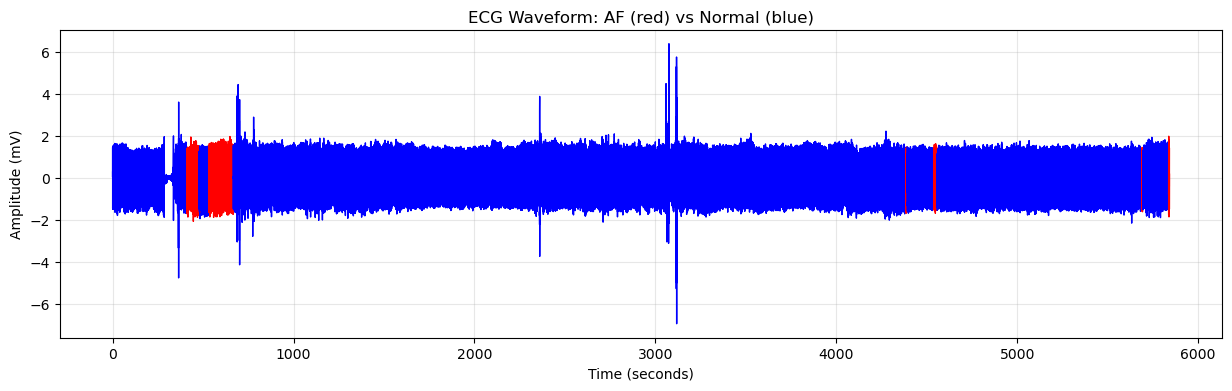

In [14]:
if clean_ecg is not None and segments is not None:
    plt.figure(figsize=(15, 4))
    
    current_pos = 0
    for seg in segments:
        start = current_pos
        end = start + (seg['end_sample'] - seg['start_sample'])
        label = seg['label']
        
        # Pilih warna: AF = red, Normal = blue
        color = 'r' if label == 1 else 'b'
        plt.plot(np.arange(start, end)/processed_fs, 
                 clean_ecg[start:end], 
                 color=color, linewidth=1)
        
        current_pos = end  # update posisi untuk concatenated signal
    
    plt.title("ECG Waveform: AF (red) vs Normal (blue)")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude (mV)")
    plt.grid(True, alpha=0.3)
    plt.show()

FEATURES: RR INTERVAL

R-Peak Detection with Neurokit

In [21]:
def detect_r_peaks_neurokit(ecg_signal, fs):
    """
    Detect R-peaks menggunakan NeuroKit2
    """
    print("=== R-peak Detection dengan NeuroKit2 ===")
    print(f"Processing signal: {len(ecg_signal):,} samples ({len(ecg_signal)/fs/60:.1f} min)")
    
    try:
        # NeuroKit2 ECG processing
        # Note: NeuroKit2 sudah include internal filtering
        signals, info = nk.ecg_process(ecg_signal, sampling_rate=fs, method='neurokit')
        
        # Extract R-peaks
        r_peaks = info['ECG_R_Peaks']
        
        print(f"✓ R-peak detection completed")
        print(f"  Total R-peaks detected: {len(r_peaks)}")
        print(f"  Average heart rate: {len(r_peaks) / (len(ecg_signal)/fs) * 60:.1f} BPM")
        
        return r_peaks, signals, info
        
    except Exception as e:
        print(f"❌ Error in R-peak detection: {e}")
        return None, None, None

# Detect R-peaks
if clean_ecg is not None:
    r_peaks, nk_signals, nk_info = detect_r_peaks_neurokit(clean_ecg, processed_fs)
else:
    print("No clean ECG signal available for R-peak detection")

=== R-peak Detection dengan NeuroKit2 ===
Processing signal: 1,460,386 samples (97.4 min)
✓ R-peak detection completed
  Total R-peaks detected: 8355
  Average heart rate: 85.8 BPM


Perbandingan R-Peaks pada Segment AF dan Segment N

Comparing R-peak detection:
AF segment: 134.0s duration
Normal segment: 3717.6s duration


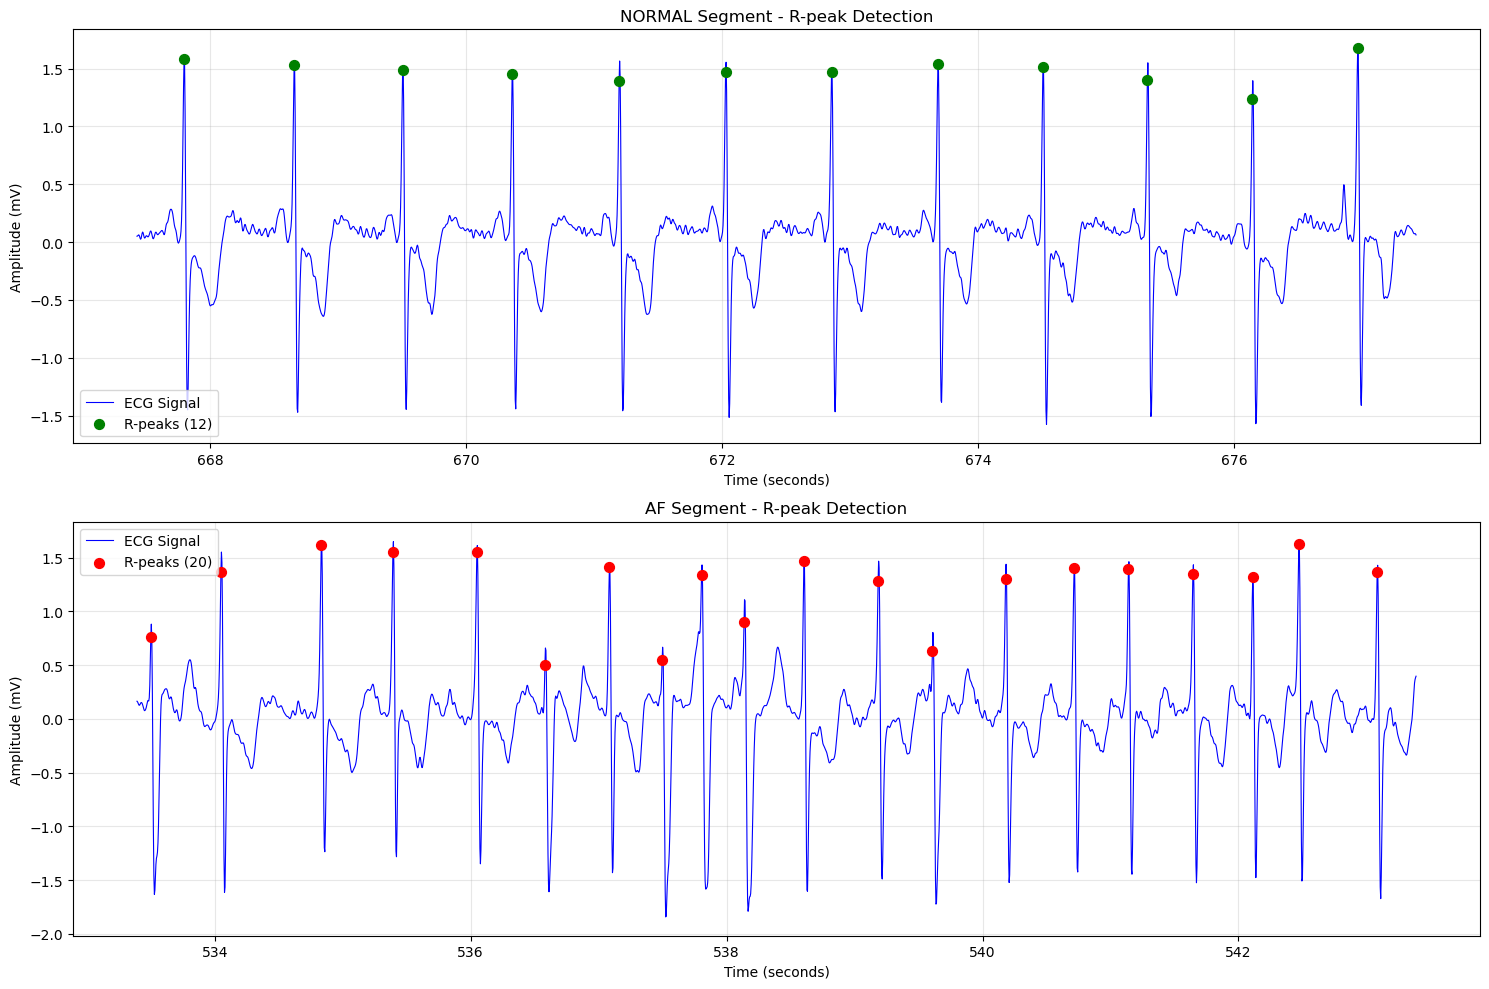


=== RR Interval Comparison ===
Normal segment RR intervals:
  Mean: 833.8 ± 14.2 ms
  Range: 816.0 - 860.0 ms
  Coefficient of variation: 1.7%
AF segment RR intervals:
  Mean: 504.4 ± 113.1 ms
  Range: 308.0 - 784.0 ms
  Coefficient of variation: 22.4%


In [31]:
def compare_r_peaks_af_vs_normal(ecg_signal, r_peaks, segments, fs, duration=10):
    """
    Compare R-peak detection pada segment AF vs Normal
    """
    if r_peaks is None or len(r_peaks) == 0:
        print("No R-peaks to compare")
        return
    
    # Find AF and Normal segments
    af_segments = [seg for seg in segments if seg['label'] == 1]
    normal_segments = [seg for seg in segments if seg['label'] == 0]
    
    if not af_segments or not normal_segments:
        print("Need both AF and Normal segments for comparison")
        return
    
    # Select representative segments (pick longest ones for better visualization)
    af_seg = max(af_segments, key=lambda x: x['duration_sec'])
    normal_seg = max(normal_segments, key=lambda x: x['duration_sec'])
    
    print(f"Comparing R-peak detection:")
    print(f"AF segment: {af_seg['duration_sec']:.1f}s duration")
    print(f"Normal segment: {normal_seg['duration_sec']:.1f}s duration")
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Normal segment
    normal_start = normal_seg['start_sample']
    normal_end = min(normal_start + int(duration * fs), normal_seg['end_sample'])
    normal_end = min(len(ecg_signal), normal_end)
    
    time_normal = np.arange(normal_start, normal_end) / fs
    ecg_normal = ecg_signal[normal_start:normal_end]
    
    # R-peaks dalam normal segment
    r_peaks_normal = [r for r in r_peaks if normal_start <= r < normal_end]
    r_times_normal = np.array(r_peaks_normal) / fs
    
    axes[0].plot(time_normal, ecg_normal, 'b-', linewidth=0.8, label='ECG Signal')
    if len(r_peaks_normal) > 0:
        axes[0].scatter(r_times_normal, ecg_signal[r_peaks_normal], 
                       color='green', marker='o', s=50, label=f'R-peaks ({len(r_peaks_normal)})', zorder=5)
    
    axes[0].set_title(f'NORMAL Segment - R-peak Detection')
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Amplitude (mV)')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Plot 2: AF segment  
    af_start = af_seg['start_sample']
    af_end = min(af_start + int(duration * fs), af_seg['end_sample'])
    af_end = min(len(ecg_signal), af_end)
    
    time_af = np.arange(af_start, af_end) / fs
    ecg_af = ecg_signal[af_start:af_end]
    
    # R-peaks dalam AF segment
    r_peaks_af = [r for r in r_peaks if af_start <= r < af_end]
    r_times_af = np.array(r_peaks_af) / fs
    
    axes[1].plot(time_af, ecg_af, 'b-', linewidth=0.8, label='ECG Signal')
    if len(r_peaks_af) > 0:
        axes[1].scatter(r_times_af, ecg_signal[r_peaks_af], 
                       color='red', marker='o', s=50, label=f'R-peaks ({len(r_peaks_af)})', zorder=5)
    
    axes[1].set_title(f'AF Segment - R-peak Detection')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].set_ylabel('Amplitude (mV)')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Compare RR intervals
    print(f"\n=== RR Interval Comparison ===")
    if len(r_peaks_normal) > 1:
        rr_normal = np.diff(r_times_normal) * 1000  # ms
        print(f"Normal segment RR intervals:")
        print(f"  Mean: {np.mean(rr_normal):.1f} ± {np.std(rr_normal):.1f} ms")
        print(f"  Range: {np.min(rr_normal):.1f} - {np.max(rr_normal):.1f} ms")
        print(f"  Coefficient of variation: {np.std(rr_normal)/np.mean(rr_normal)*100:.1f}%")
    
    if len(r_peaks_af) > 1:
        rr_af = np.diff(r_times_af) * 1000  # ms
        print(f"AF segment RR intervals:")
        print(f"  Mean: {np.mean(rr_af):.1f} ± {np.std(rr_af):.1f} ms")
        print(f"  Range: {np.min(rr_af):.1f} - {np.max(rr_af):.1f} ms")
        print(f"  Coefficient of variation: {np.std(rr_af)/np.mean(rr_af)*100:.1f}%")

# Compare R-peaks AF vs Normal
compare_r_peaks_af_vs_normal(clean_ecg, r_peaks, segments, processed_fs, duration=10)

Calculate RR Intervals dengan Segment Labels

In [43]:
def calculate_rr_intervals_with_labels(r_peaks, segments, fs):
    """
    Calculate RR intervals dan assign labels berdasarkan segments
    """
    if r_peaks is None or len(r_peaks) < 2:
        print("Insufficient R-peaks for RR interval calculation")
        return None, None
    
    print("=== Calculating RR Intervals ===")
    
    # Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(r_peaks) / fs * 1000
    
    print(f"Total RR intervals: {len(rr_intervals)}")
    print(f"RR interval statistics:")
    print(f"  Mean: {np.mean(rr_intervals):.1f} ms")
    print(f"  Std: {np.std(rr_intervals):.1f} ms")
    print(f"  Min: {np.min(rr_intervals):.1f} ms")
    print(f"  Max: {np.max(rr_intervals):.1f} ms")
    
    # Assign labels untuk each RR interval
    rr_labels = []
    rr_peak_positions = r_peaks[:-1]  # Positions for each RR interval
    
    for i, rr_peak_pos in enumerate(rr_peak_positions):
        # Find which segment contains this R-peak
        segment_label = 0  # Default normal
        
        for seg in segments:
            if seg['start_sample'] <= rr_peak_pos < seg['end_sample']:
                segment_label = seg['label']
                break
        
        rr_labels.append(segment_label)
    
    rr_labels = np.array(rr_labels)
    
    print(f"\nRR interval labels:")
    print(f"  AF RR intervals: {np.sum(rr_labels == 1)} ({np.sum(rr_labels == 1)/len(rr_labels)*100:.1f}%)")
    print(f"  Normal RR intervals: {np.sum(rr_labels == 0)} ({np.sum(rr_labels == 0)/len(rr_labels)*100:.1f}%)")
    
    return rr_intervals, rr_labels, rr_peak_positions

# # Calculate RR intervals dengan labels
# if all(var in locals() for var in ['r_peaks', 'segments']):
#     rr_intervals, rr_labels, rr_positions = calculate_rr_intervals_with_labels(
#         r_peaks, segments, processed_fs
#     )
#     print("\n✅ RR intervals calculated successfully")
# else:
#     print("❌ Required variables not available")

if clean_ecg is not None and segments is not None and r_peaks is not None:
    rr_intervals, rr_labels, rr_positions = calculate_rr_intervals_with_labels(
        r_peaks, segments, processed_fs
    )
    print("\n✅ RR intervals calculated successfully")
else:
    print("❌ Required variables not available or None")

=== Calculating RR Intervals ===
Total RR intervals: 8354
RR interval statistics:
  Mean: 699.1 ms
  Std: 166.5 ms
  Min: 304.0 ms
  Max: 2340.0 ms

RR interval labels:
  AF RR intervals: 521 (6.2%)
  Normal RR intervals: 7833 (93.8%)

✅ RR intervals calculated successfully


Create RR Sequences untuk BiLSTM

In [44]:
def create_rr_sequences(rr_intervals, rr_labels, sequence_length=20, overlap_ratio=0.5):
    """
    Create fixed-length RR sequences untuk BiLSTM training
    
    Parameters:
    -----------
    rr_intervals : array
        Array of RR intervals dalam ms
    rr_labels : array
        Labels untuk setiap RR interval (0=Normal, 1=AF)
    sequence_length : int
        Panjang sequence untuk setiap sample
    overlap_ratio : float
        Overlap ratio antar sequences (0-1)
    """
    
    print(f"=== Creating RR Sequences ===")
    print(f"Sequence length: {sequence_length} RR intervals")
    print(f"Overlap ratio: {overlap_ratio}")
    
    if len(rr_intervals) < sequence_length:
        print("❌ Not enough RR intervals for sequence creation")
        return None, None
    
    # Calculate step size
    step_size = int(sequence_length * (1 - overlap_ratio))
    if step_size < 1:
        step_size = 1
    
    sequences = []
    sequence_labels = []
    
    # Create sequences dengan sliding window
    for i in range(0, len(rr_intervals) - sequence_length + 1, step_size):
        # Extract sequence
        sequence = rr_intervals[i:i + sequence_length]
        
        # Label assignment strategy: majority voting dalam sequence
        sequence_rr_labels = rr_labels[i:i + sequence_length]
        
        # Majority vote untuk sequence label
        af_count = np.sum(sequence_rr_labels == 1)
        normal_count = np.sum(sequence_rr_labels == 0)
        
        if af_count > normal_count:
            sequence_label = 1  # AF
        elif normal_count > af_count:
            sequence_label = 0  # Normal
        else:
            # Tie case - skip atau assign berdasarkan threshold
            continue  # Skip ambiguous sequences
        
        sequences.append(sequence)
        sequence_labels.append(sequence_label)
    
    sequences = np.array(sequences)
    sequence_labels = np.array(sequence_labels)
    
    print(f"\nSequence creation results:")
    print(f"  Total sequences: {len(sequences)}")
    print(f"  AF sequences: {np.sum(sequence_labels == 1)} ({np.sum(sequence_labels == 1)/len(sequence_labels)*100:.1f}%)")
    print(f"  Normal sequences: {np.sum(sequence_labels == 0)} ({np.sum(sequence_labels == 0)/len(sequence_labels)*100:.1f}%)")
    print(f"  Sequence shape: {sequences.shape}")
    
    return sequences, sequence_labels

# Create RR sequences
if 'rr_intervals' in locals() and 'rr_labels' in locals():
    rr_sequences, sequence_labels = create_rr_sequences(
        rr_intervals, 
        rr_labels, 
        sequence_length=20,  # 20 RR intervals per sequence
        overlap_ratio=0.5    # 50% overlap
    )
    
    if rr_sequences is not None:
        print("\n✅ RR sequences created successfully")
    else:
        print("❌ Failed to create RR sequences")

=== Creating RR Sequences ===
Sequence length: 20 RR intervals
Overlap ratio: 0.5

Sequence creation results:
  Total sequences: 833
  AF sequences: 48 (5.8%)
  Normal sequences: 785 (94.2%)
  Sequence shape: (833, 20)

✅ RR sequences created successfully


Visualisasi RR Sequences

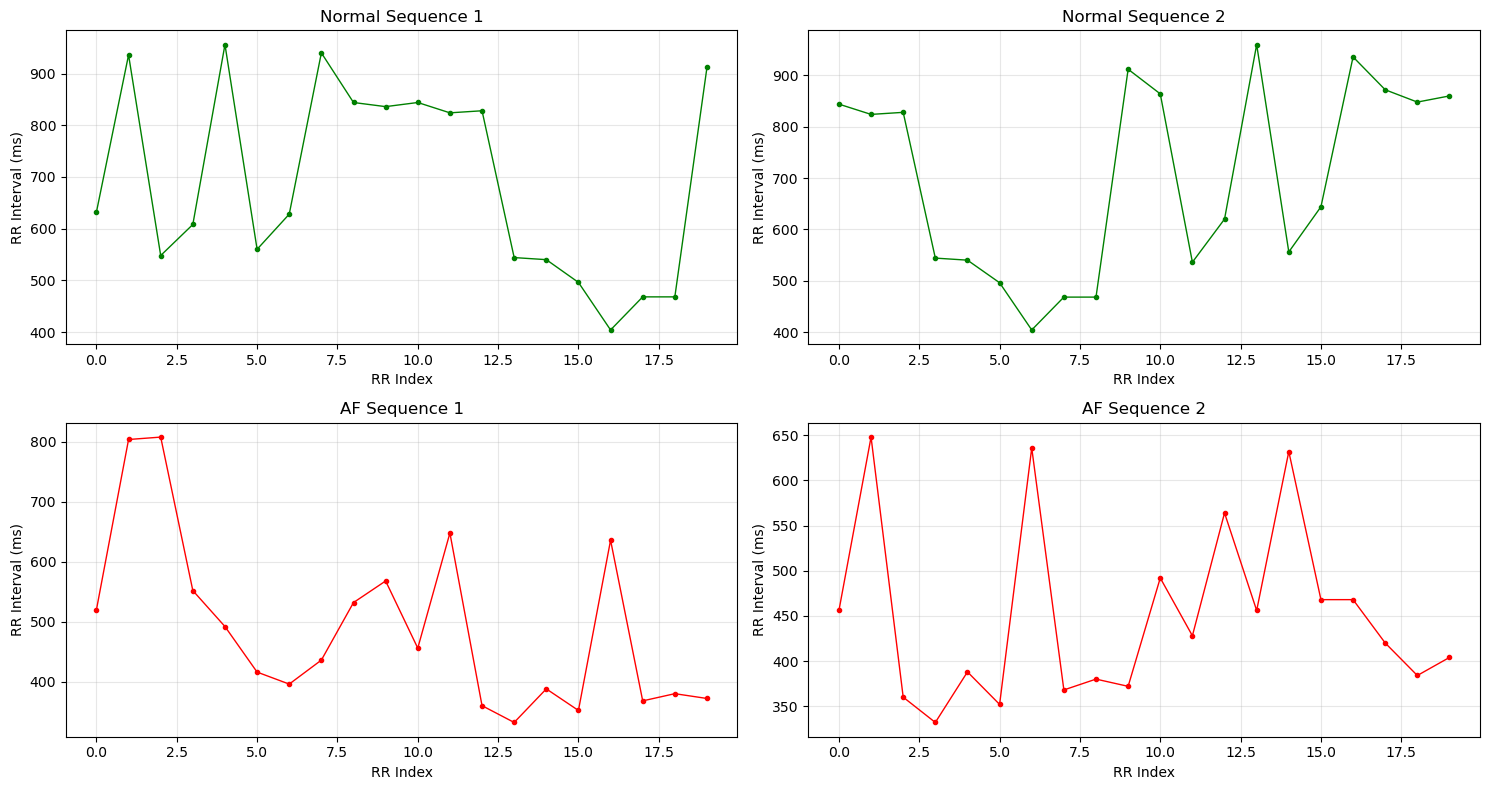


=== Sequence Statistics ===
Normal sequences:
  Mean RR: 714.2 ± 157.8 ms
  RR range: 304.0 - 2340.0 ms
  Avg within-sequence std: 94.0 ms
AF sequences:
  Mean RR: 456.7 ± 99.7 ms
  RR range: 304.0 - 1084.0 ms
  Avg within-sequence std: 88.3 ms


In [45]:
def visualize_rr_sequences(sequences, labels, num_samples=4):
    """
    Visualize sample RR sequences untuk AF dan Normal
    """
    if sequences is None or len(sequences) == 0:
        print("No sequences to visualize")
        return
    
    # Get sample sequences
    af_indices = np.where(labels == 1)[0]
    normal_indices = np.where(labels == 0)[0]
    
    num_per_class = num_samples // 2
    
    fig, axes = plt.subplots(2, num_per_class, figsize=(15, 8))
    if num_per_class == 1:
        axes = axes.reshape(2, 1)
    
    # Plot Normal sequences
    for i in range(min(num_per_class, len(normal_indices))):
        idx = normal_indices[i]
        sequence = sequences[idx]
        
        axes[0, i].plot(sequence, 'g-', marker='o', linewidth=1, markersize=3)
        axes[0, i].set_title(f'Normal Sequence {i+1}')
        axes[0, i].set_xlabel('RR Index')
        axes[0, i].set_ylabel('RR Interval (ms)')
        axes[0, i].grid(True, alpha=0.3)
    
    # Plot AF sequences
    for i in range(min(num_per_class, len(af_indices))):
        idx = af_indices[i]
        sequence = sequences[idx]
        
        axes[1, i].plot(sequence, 'r-', marker='o', linewidth=1, markersize=3)
        axes[1, i].set_title(f'AF Sequence {i+1}')
        axes[1, i].set_xlabel('RR Index')
        axes[1, i].set_ylabel('RR Interval (ms)')
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Sequence statistics
    print(f"\n=== Sequence Statistics ===")
    
    if len(normal_indices) > 0:
        normal_seqs = sequences[normal_indices]
        print(f"Normal sequences:")
        print(f"  Mean RR: {np.mean(normal_seqs):.1f} ± {np.std(normal_seqs):.1f} ms")
        print(f"  RR range: {np.min(normal_seqs):.1f} - {np.max(normal_seqs):.1f} ms")
        print(f"  Avg within-sequence std: {np.mean([np.std(seq) for seq in normal_seqs]):.1f} ms")
    
    if len(af_indices) > 0:
        af_seqs = sequences[af_indices]
        print(f"AF sequences:")
        print(f"  Mean RR: {np.mean(af_seqs):.1f} ± {np.std(af_seqs):.1f} ms")
        print(f"  RR range: {np.min(af_seqs):.1f} - {np.max(af_seqs):.1f} ms")
        print(f"  Avg within-sequence std: {np.mean([np.std(seq) for seq in af_seqs]):.1f} ms")

# Visualize RR sequences
if 'rr_sequences' in locals() and 'sequence_labels' in locals():
    visualize_rr_sequences(rr_sequences, sequence_labels, num_samples=4)

Data Normalization

In [46]:
def normalize_rr_sequences(sequences, method='minmax'):
    """
    Normalize RR sequences untuk neural network training
    
    Parameters:
    -----------
    sequences : array
        Array of RR sequences (samples, sequence_length)
    method : str
        Normalization method: 'minmax', 'zscore', 'robust'
    """
    
    print(f"=== Normalizing RR Sequences ===")
    print(f"Method: {method}")
    print(f"Original data range: {np.min(sequences):.1f} - {np.max(sequences):.1f} ms")
    
    if method == 'minmax':
        # Min-Max normalization (0-1)
        min_val = np.min(sequences)
        max_val = np.max(sequences)
        normalized_sequences = (sequences - min_val) / (max_val - min_val)
        
        normalization_params = {'method': 'minmax', 'min_val': min_val, 'max_val': max_val}
        
    elif method == 'zscore':
        # Z-score normalization (mean=0, std=1)
        mean_val = np.mean(sequences)
        std_val = np.std(sequences)
        normalized_sequences = (sequences - mean_val) / std_val
        
        normalization_params = {'method': 'zscore', 'mean_val': mean_val, 'std_val': std_val}
        
    elif method == 'robust':
        # Robust normalization (median, IQR)
        median_val = np.median(sequences)
        q75 = np.percentile(sequences, 75)
        q25 = np.percentile(sequences, 25)
        iqr = q75 - q25
        
        normalized_sequences = (sequences - median_val) / iqr
        
        normalization_params = {'method': 'robust', 'median_val': median_val, 'iqr': iqr}
    
    else:
        print("❌ Unknown normalization method")
        return None, None
    
    print(f"Normalized data range: {np.min(normalized_sequences):.3f} - {np.max(normalized_sequences):.3f}")
    print(f"✅ Normalization completed")
    
    return normalized_sequences, normalization_params

# Normalize sequences
if 'rr_sequences' in locals():
    normalized_sequences, norm_params = normalize_rr_sequences(
        rr_sequences, 
        method='minmax'  # atau 'zscore', 'robust'
    )
    
    print(f"\nNormalization parameters saved for inference:")
    print(f"  {norm_params}")

=== Normalizing RR Sequences ===
Method: minmax
Original data range: 304.0 - 2340.0 ms
Normalized data range: 0.000 - 1.000
✅ Normalization completed

Normalization parameters saved for inference:
  {'method': 'minmax', 'min_val': np.float64(304.0), 'max_val': np.float64(2340.0)}


Prepare Data untuk BiLSTM

In [47]:
def prepare_bilstm_data(sequences, labels, test_size=0.2, random_state=42):
    """
    Prepare data untuk BiLSTM training
    """
    from sklearn.model_selection import train_test_split
    from sklearn.utils import shuffle
    
    print("=== Preparing Data untuk BiLSTM ===")
    
    # Shuffle data
    sequences, labels = shuffle(sequences, labels, random_state=random_state)
    
    # Reshape untuk BiLSTM: (samples, timesteps, features)
    X = sequences.reshape(sequences.shape[0], sequences.shape[1], 1)
    y = labels
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    print(f"Data shapes:")
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test: {X_test.shape}")
    print(f"  y_train: {y_train.shape}")
    print(f"  y_test: {y_test.shape}")
    
    print(f"\nClass distribution:")
    print(f"  Train - AF: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
    print(f"  Train - Normal: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
    print(f"  Test - AF: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")
    print(f"  Test - Normal: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
    
    return X_train, X_test, y_train, y_test

# Prepare data for BiLSTM
if 'normalized_sequences' in locals() and 'sequence_labels' in locals():
    X_train, X_test, y_train, y_test = prepare_bilstm_data(
        normalized_sequences, 
        sequence_labels,
        test_size=0.2
    )
    
    print("\n✅ Data prepared untuk BiLSTM training")
    print("🔄 Ready for model development")

=== Preparing Data untuk BiLSTM ===
Data shapes:
  X_train: (666, 20, 1)
  X_test: (167, 20, 1)
  y_train: (666,)
  y_test: (167,)

Class distribution:
  Train - AF: 38 (5.7%)
  Train - Normal: 628 (94.3%)
  Test - AF: 10 (6.0%)
  Test - Normal: 157 (94.0%)

✅ Data prepared untuk BiLSTM training
🔄 Ready for model development


Save Processed Data

In [48]:
# Save semua processed data untuk model training
if all(var in locals() for var in ['X_train', 'X_test', 'y_train', 'y_test', 'norm_params']):
    
    # Create data dictionary
    processed_data = {
        'record_id': record_id,
        'sampling_frequency': processed_fs,
        'sequence_length': rr_sequences.shape[1] if 'rr_sequences' in locals() else None,
        'total_sequences': len(sequence_labels) if 'sequence_labels' in locals() else 0,
        'normalization_params': norm_params,
        'X_train': X_train,
        'X_test': X_test, 
        'y_train': y_train,
        'y_test': y_test,
        'class_distribution': {
            'train_af': int(np.sum(y_train == 1)),
            'train_normal': int(np.sum(y_train == 0)),
            'test_af': int(np.sum(y_test == 1)),
            'test_normal': int(np.sum(y_test == 0))
        }
    }
    
    print("✅ Complete RR sequence preprocessing finished!")
    print(f"\n=== Final Data Summary ===")
    print(f"Record ID: {processed_data['record_id']}")
    print(f"Sequence length: {processed_data['sequence_length']} RR intervals")
    print(f"Total sequences: {processed_data['total_sequences']}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Input shape for BiLSTM: {X_train.shape}")
    
    print(f"\n🔄 Ready for BiLSTM model development:")
    print("  - Input: RR interval sequences")
    print("  - Architecture: Bidirectional LSTM")
    print("  - Task: Binary classification (AF vs Normal)")
    
    # Optional: save to file
    # np.savez(f'rr_sequences_{record_id}.npz', **processed_data)
    # print(f"Data saved to: rr_sequences_{record_id}.npz")
    
else:
    print("❌ Some preprocessing steps incomplete")
    missing = [var for var in ['X_train', 'X_test', 'y_train', 'y_test'] 
               if var not in locals()]
    print(f"Missing variables: {missing}")

❌ Some preprocessing steps incomplete
Missing variables: ['X_train', 'X_test', 'y_train', 'y_test']
